In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [2]:
import random
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Patchifying and linear mapping:

The transformer encoder was developed with a sequence data in mind such as English sentences. We can do this by reshaping 
the input of say size in this context (N,C,H,W) for MNIST example (N,1,28,28) to size (N, /#patches, Path dimension).
The patch dimension is adjusted according to needs. 

In this example, we are splitting it into 7x7 patches so each of the sub images is a 4x4 image. thereby getting a 7x7=49 sub images
from a single input. 

![part1:split](https://github.com/jiztom/jiztom.github.io/assets/47367860/50d5efe8-49fe-4221-a8c0-56705d85e1dd)


Notice that each patch is a picture of size 1x4x4, we will flatten into a 16 dimensional vecor. Here its a single channel
but in case of multichannel we will also flatten it into a single 1D vector.

we modify the myViT class to implement the patchifying only. Not the most efficient method but its the best to learn
the process.

In [3]:
import numpy as np
train_norm = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_train_02292024.npy'
train_yield = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_yield_train.npy'


In [4]:
data_train = np.load(train_norm)
data_tensor = torch.from_numpy(data_train)
data_tensor = data_tensor.permute(2, 1, 0)
data_tensor.shape

torch.Size([93028, 214, 7])

In [5]:
train_label = np.load(train_yield)
label_tensor = torch.from_numpy(train_label)
label_tensor.shape

torch.Size([93028, 1])

In [6]:
from torch.utils.data import Dataset
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data_tensor = data_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        sample = self.data_tensor[idx]
        label = self.labels_tensor[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label



In [7]:
from torchvision import transforms

# Define any required transformations
transform = transforms.Compose([
    # Add any transformations you need here
])


In [8]:
from torch.utils.data import Dataset, DataLoader
dataset = CustomTensorDataset(data_tensor=data_tensor, labels_tensor=label_tensor, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [9]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(dataloader,'training loader')

---------training loader---------
93028
torch.Size([32, 214, 7])
torch.Size([32, 1])


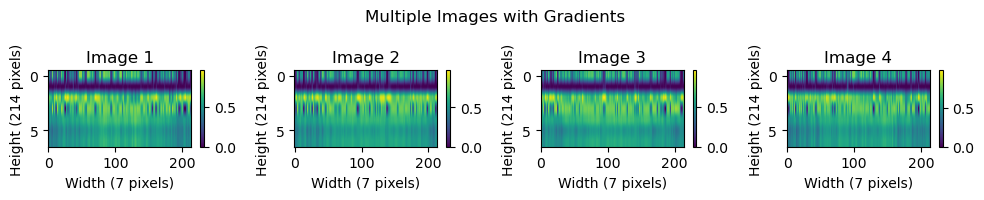

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: creating multiple images with dimensions 214x7
num_images = 4
# images = [dataset[idx] for _ in range(num_images)]

# Plot the images with gradients
fig, axes = plt.subplots(1, num_images, figsize=(10, 2))  # Create subplots

for i, ax in enumerate(axes):
    img = dataset[i][0].transpose(1, 0)
    cax = ax.imshow(img, aspect='auto', cmap='viridis')
    ax.set_title(f"Image {i+1}")
    ax.set_xlabel("Width (7 pixels)")
    ax.set_ylabel("Height (214 pixels)")
    fig.colorbar(cax, ax=ax, orientation='vertical')  # Add color bar to each subplot

plt.suptitle("Multiple Images with Gradients")
plt.tight_layout()
plt.show()


In [11]:
import torch

def img_to_non_square_patch(x, patch_size_h, patch_size_w, flatten_channels=True):
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size_h, patch_size_h, W // patch_size_w, patch_size_w)
    x = x.permute(0, 2, 4, 1, 3, 5)
    x = x.flatten(1, 2)
    if flatten_channels:
        x = x.flatten(2, 4)
    return x

In [12]:

# Example usage
image = torch.randn(1, 1, 214, 7)  # Example image tensor with shape [B, C, H, W]
patch_size_h = 107  # Choose a patch height that is a factor of 214
patch_size_w = 7  # Choose a patch width that is a factor of 7
patches = img_to_non_square_patch(image, patch_size_h, patch_size_w)
print(f"Patches shape: {patches.shape}")

Patches shape: torch.Size([1, 2, 749])


In [13]:
import torch
import torch.nn.functional as F

def pad_image(image, patch_size_h, patch_size_w):
    B, C, H, W = image.shape
    pad_h = (patch_size_h - (H % patch_size_h)) % patch_size_h
    pad_w = (patch_size_w - (W % patch_size_w)) % patch_size_w
    
    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_image = F.pad(image, padding)
    return padded_image

In [14]:

# Example usage
# image = torch.randn(1, 1, 214, 7)  # Example image tensor with shape [B, C, H, W]
# Get the first sample
image, first_label = next(iter(dataloader))
print(image.shape)

torch.Size([32, 214, 7])


In [15]:

patch_size_h = 50  # Example patch height
patch_size_w = 7  # Example patch width
padded_image = pad_image(image.unsqueeze(0), patch_size_h, patch_size_w)
print(f"Padded image shape: {padded_image.shape}")

# Now, define patches for the padded image
patches = img_to_non_square_patch(padded_image, patch_size_h, patch_size_w,flatten_channels=False)
print(f"Patches shape: {patches.shape}")


Padded image shape: torch.Size([1, 32, 250, 7])
Patches shape: torch.Size([1, 5, 32, 50, 7])


In [16]:
image_size = 250
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=50
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

model_save_path = r'/home/jiztom/PycharmProjects/image-based-transformer/VisualTransformer/Model_save'
epoch_range = 50

patch_size_h = 50  # Example patch height
patch_size_w = 7  # Example patch width

In [17]:
dataset[0][0].shape

torch.Size([214, 7])

In [18]:
import torchvision
NUM_IMAGES = 4
examples = torch.stack([dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)


In [19]:
examples.shape

torch.Size([4, 214, 7])

In [20]:
# Visualize the image patches
patch_size_h,patch_size_w  = 4 , 4
padded_image = pad_image(examples.unsqueeze(0), patch_size_h, patch_size_w)
print(f"Padded image shape: {padded_image.shape}")

Padded image shape: torch.Size([1, 4, 216, 8])


In [45]:
# Function to convert image to patches
def img_to_patch(x, patch_size_h, patch_size_w, flatten_channels=True):
    B, C, H, W = x.shape  # [B, C, H, W]
    assert H % patch_size_h == 0 and W % patch_size_w == 0, "Image dimensions must be divisible by the patch size."
    x = x.reshape(B, C, H // patch_size_h, patch_size_h, W // patch_size_w, patch_size_w)  # [B, C, H//p_h, p_h, W//p_w, p_w]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H//p_h, W//p_w, C, p_h, p_w]
    x = x.flatten(1, 2)  # [B, (H//p_h)*(W//p_w), C, p_h, p_w]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, (H//p_h)*(W//p_w), C*p_h*p_w]
    return x

# Function to convert image to patches with debug information
def img_to_patch_debug(x, patch_size, flatten_channels=True):
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by the patch size."
    print(f"Original Image Shape: {x.shape}")

    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    print(f"After Reshape: {x.shape}")

    x = x.permute(0, 2, 4, 1, 3, 5)
    print(f"After Permute: {x.shape}")

    x = x.flatten(1, 2)
    print(f"After Flatten: {x.shape}")

    if flatten_channels:
        x = x.flatten(2, 4)
        print(f"After Channel Flatten: {x.shape}")

    return x
# Example usage of img_to_patch function
image = padded_image
patch_size_h = 4  # Patch height
patch_size_w = 4  # Patch width

# Convert image to patches
# patches = img_to_patch(image, patch_size_h, patch_size_w)
patches = img_to_patch_debug(image, patch_size_h, patch_size_w)
print(f"Patches shape: {patches.shape}")  # Output: [B, (216//4)*(8//4), C*p_h*p_w]


Original Image Shape: torch.Size([1, 4, 216, 8])
After Reshape: torch.Size([1, 4, 54, 4, 2, 4])
After Permute: torch.Size([1, 54, 2, 4, 4, 4])
After Flatten: torch.Size([1, 108, 4, 4, 4])
After Channel Flatten: torch.Size([1, 108, 64])
Patches shape: torch.Size([1, 108, 64])


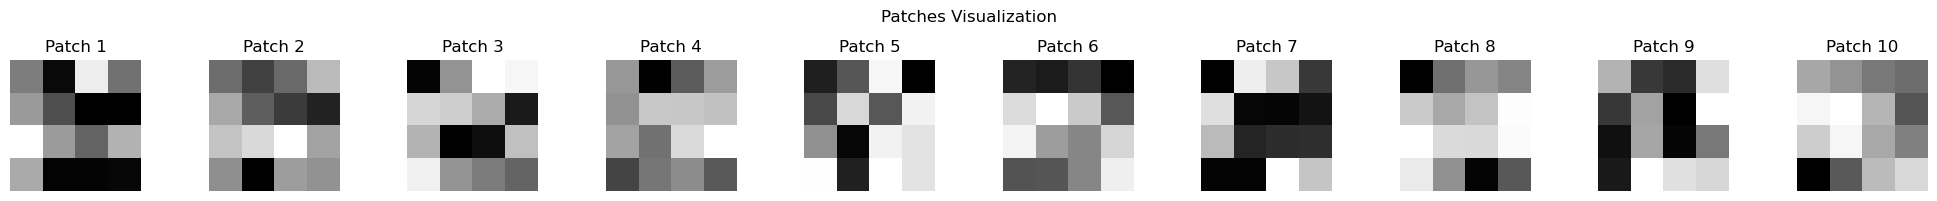

In [35]:
# Example visualization of patches
num_patches = patches.shape[1]
fig, axes = plt.subplots(1, min(num_patches, 10), figsize=(min(num_patches, 10) * 2, 2))  # Create subplots

for i, ax in enumerate(axes):
    if i >= num_patches:
        break
    patch = patches[0, i].reshape(patch_size_h, patch_size_w, -1).permute(2, 0, 1)  # Reshape to original patch size and permute for channel first
    ax.imshow(patch[0].cpu().numpy(), cmap='gray')  # Assuming single-channel for visualization
    ax.set_title(f"Patch {i+1}")
    ax.axis('off')

plt.suptitle("Patches Visualization")
plt.tight_layout()
plt.show()

In [37]:
# Visualization function for patches
def visualize_patches(patches, patch_size_h, patch_size_w, num_patches=10):
    fig, axes = plt.subplots(1, num_patches, figsize=(15, 5))
    for i, ax in enumerate(axes):
        patch = patches[0, i].reshape(patch_size_h, patch_size_w, -1).permute(2, 0, 1).cpu().numpy()
        ax.imshow((patch - patch.min()) / (patch.max() - patch.min()))
        ax.axis('off')
    plt.show()
    
visualize_patches(patches, 4, 4, num_patches)

In [38]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        # Super constructor
        super(MyViT, self).__init__()
        # Attributes
        self.chw = chw # (C, H, W)
        self.n_patches = n_patches
        
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classifiation token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
        self.pos_embed.requires_grad = False
      
    def forward(self, images):
        padded_image = pad_image(examples.unsqueeze(0), patch_size_h, patch_size_w)
        patches = img_to_patch(padded_image, self.n_patches)
        # patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        
        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(n, 1, 1)
        out = tokens + pos_embed
        return out
    

## Adding the classification token
In the architecture we see that "v_class" token also being passed to the transformer Encoder. This is a special token passed for capturing the information about other tokens. Will work at the MSA block when the information from all other tokens are present. initial value of the special token is a parameter of the model tha needs to be learned.

we can always add another special token at the end downstream for anohter task example to classify if the value is greater than or equal to 5.
Now we add a parameter to our model to convert (N,49,*) tokens tensor to an (N,50,8) tensor

Note that the classification token is put in as the first token of each sequence.


## Positional Encoding
Based on the work by [Vaswani et. al](https://arxiv.org/abs/1706.03762) suggest we can add sines and the cosine waves.

In particular, positional encoding adds high-freqyebct values to teh first dimensions and low-frequency values to the latter dimensions.

in each sequence, for token i we add to its j-th coordinate the following value:

![image](https://github.com/jiztom/jiztom.github.io/assets/47367860/48d64952-4ecc-4317-beda-9772cb293e4c)

This positional embedding is a function of the number of elements in the sequence and the dimensionality of each element. Thus, it is always a 2-dimensional tensor or “rectangle”.

Here’s a simple function that, given the number of tokens and the dimensionality of each of them, outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.


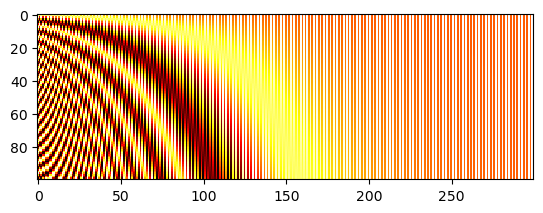

In [24]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

From the heatmap we have plotted, we see that all ‘horizontal lines’ are all different from each other, and thus samples can be distinguished.

We can now add this positional encoding to our model after the linear mapping and the addition of the class token.

We define the positional embedding to be a parameter of our model (that we won’t update by setting its requires_grad to False). Note that in the forward method, since tokens have size (N, 50, 8), we have to repeat the (50, 8) positional encoding matrix N times.

## The Encoder block (part 1)
An encoder block takes the current tensor [N,S,D] as the input and teh outputs of a tensor of the same dimensionality.

We split the encoder block into two parts
The first part consists of the following:
### Layer Normalization
layer normalization is a popular block that when given an input substracts its mean and divides by the standard deviation. 
Normally Layer normalization works for an (N,d) where d is the dimensionality. But it works even when expanded to support multi dimension.

In [25]:
import torch
import torch.nn as nn

ln =nn.LayerNorm(8)
ln(torch.rand(50,8)).shape

torch.Size([50, 8])

In [26]:
ln(torch.rand(16,50,8)).shape

torch.Size([16, 50, 8])

### Multi-head Self Attention
we want for a single image each patch to get updated based on some similarity measure with other patches. It is made possible by mapping each patch (currently an 8 dimensional vector in our specific example) to 3 distinct vectors **q,k,v** (Querym key and value)

Now for each patch we are going to compute the dot product between its q vector with all of the k vectors, divide by the square root of the dimenionality of these vectors (in our case $\sqrt(8)$) softmax these so-called attention cues and finally multiple each attention cue with the v vectors associated with different k vectors and sum all of it up.

 

In [39]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [40]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [41]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


In [47]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        # padded_image = pad_image(examples.unsqueeze(0), patch_size_h, patch_size_w)
        padded_image = pad_image(examples.unsqueeze(0), 4, 4)
        patches = img_to_patch(padded_image, self.n_patches)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [48]:
def main():
    # Loading data
    transform = ToTensor()
    
    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)
    
    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    # model = MyVit((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005
    
    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
        
            train_loss += loss.detach().cpu().item() / len(train_loader)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
    
    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)
        
            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [49]:
patch_size_h = 4  # Patch height
patch_size_w = 4  
main()

Using device:  cuda (NVIDIA GeForce RTX 3060 Ti)


Training:   0%|          | 0/5 [00:00<?, ?it/s]             


TypeError: img_to_patch() missing 1 required positional argument: 'patch_size_w'